In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# DISC score computation function
def compute_disc(pred, label):
    intersection = np.sum(label * pred)
    return (2.0 * intersection) / (np.sum(label) + np.sum(pred))


# Calculate IoU
def comput_iou(pred, label):
    intersection = np.sum(label * pred)
    union = np.sum(label) + np.sum(pred) - intersection
    return intersection / union

In [50]:
# Load images and labels
img_path = "processed_data/bccd/images/0a3b53c7-e7ab-4135-80aa-fd2079d727d6.npy"
lbl_path = "processed_data/bccd/labels/0a3b53c7-e7ab-4135-80aa-fd2079d727d6.npy"

img = np.load(img_path)
lbl = np.load(lbl_path)

print("Input image shape:", img.shape)
print("Label image shape:", lbl.shape)

Input image shape: (512, 512, 3)
Label image shape: (512, 512)


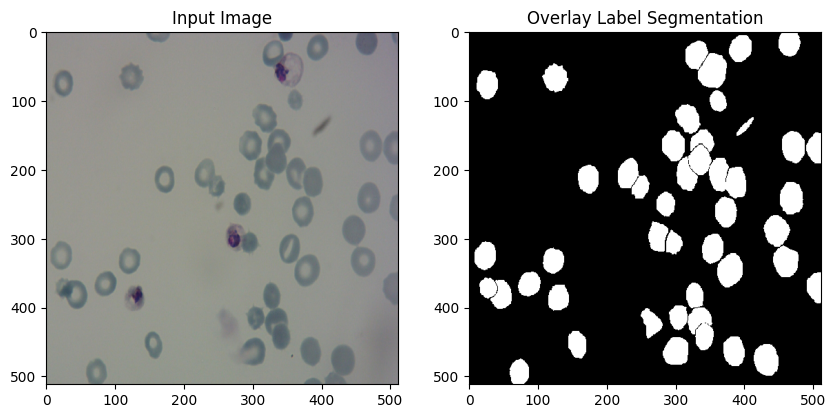

In [52]:
# Visualize input image and overlay label segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(lbl, cmap="gray")
plt.title("Overlay Label Segmentation")
plt.show()

In [34]:
from sklearn.mixture import GaussianMixture


# Flatten the image for clustering
flat_img = img.reshape((-1, img.shape[-1]))
flat_lbl = lbl.reshape(-1)

# Fit GMM to the data
gmm = GaussianMixture(n_components=2, covariance_type="tied", random_state=0)
gmm.fit(flat_img)
segmentation = gmm.predict(flat_img).reshape(img.shape[:2])

# Since GMM gives labels 0 or 1, we can directly use it as a binary mask
segmentation_mapped = segmentation


# Evaluate Mean Shift results by using DISC score and IoU
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred))


# Evaluate using DISC score
label_binary = (lbl > 0).astype(int)
pred_binary = (segmented_img > 0).astype(int)
disc_score = compute_disc(pred_binary, label_binary)
print(f"DISC Score: {disc_score}")

# Evaluate using IoU
iou_score = comput_iou(pred_binary, label_binary)
print(f"IoU Score: {iou_score}")

DISC Score: 0.8298272999826557
IoU Score: 0.709149427234421


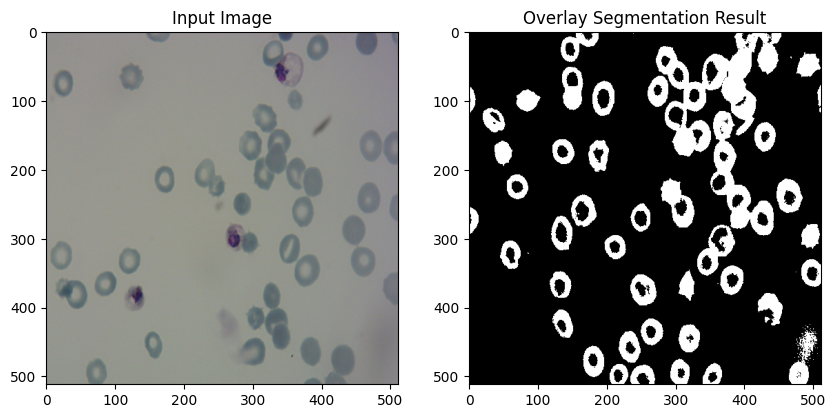

In [54]:
# Visualize overlay segmentation results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(pred_binary, cmap="gray")
plt.title("Overlay Segmentation Result")
plt.show()

# Data preparation

In [35]:
import os
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from tqdm import tqdm  # For progress bar

In [36]:
# Defining the directories
images_dir = "processed_data/bccd/images/"
labels_dir = "processed_data/bccd/labels/"
output_dir = "processed_data/bccd/labels_sement/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Retrieve file lists
image_files = [f for f in os.listdir(images_dir) if f.endswith(".npy")]
label_files = [f for f in os.listdir(labels_dir) if f.endswith(".npy")]

# Ensure the list of files matches
assert set(image_files) == set(label_files), "Mismatch between image and label files."

print(f"Found {len(image_files)} image files.")
print(f"Found {len(label_files)} label files.")

Found 1169 image files.
Found 1169 label files.


In [ ]:
# Process each pair of image and label files
store_results = []
for filename in tqdm(image_files, desc="Processing files"):
    # if filename != "0a3b53c7-e7ab-4135-80aa-fd2079d727d6.npy":
    #     continue

    # Load the image and label files
    img = np.load(os.path.join(images_dir, filename))
    lbl = np.load(os.path.join(labels_dir, filename))

    # Flatten the image for clustering
    flat_img = img.reshape((-1, img.shape[-1]))
    flat_lbl = lbl.reshape(-1)

    # Fit GMM to the data
    gmm = GaussianMixture(n_components=2, covariance_type="tied", random_state=0)
    gmm.fit(flat_img)
    segmentation = gmm.predict(flat_img).reshape(img.shape[:2])

    # Evaluate using DISC score
    label_binary = (lbl > 0).astype(int)
    pred_binary = (segmentation > 0).astype(int)
    disc_score = compute_disc(pred_binary, label_binary)
    print(f"DISC Score: {disc_score}")

    # Evaluate using IoU
    iou_score = comput_iou(pred_binary, label_binary)
    print(f"IoU Score: {iou_score}")

    # Save the segmentation labels
    output_path = os.path.join(output_dir, filename)
    print(f"Saving segmentation to {output_path}")
    np.save(output_path, pred_binary)

    # store results
    store_results.append([filename, pred_binary, disc_score, iou_score])

In [42]:
pd_results = pd.DataFrame(
    store_results, columns=["filename", "segmentation", "disc_score", "iou_score"]
)
pd_results

,filename,segmentation,disc_score,iou_score
0,c2ec116f-f091-422c-926c-70b548a8f6ef.npy,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,...",0.948920,0.902805
1,84ee2ea3-9edd-4672-a1b3-f09c607d833a.npy,"[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.007868,0.003950
2,065af549-320a-4862-b92a-8ef750d7b5fb.npy,"[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.959998,0.923073
3,42e87148-a015-4148-923a-fb83016f64e7.npy,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,...",0.898069,0.814996
4,06a3effb-996c-4767-afd2-6aa3b697cb4e.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.921086,0.853715
...,...,...,...,...
1164,674b0fd3-f247-4b7f-97f7-3e6c57c9ba9e.npy,"[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.923764,0.858328
1165,540a5fee-175b-4b92-bf62-1ea9b59c86c6.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",0.923871,0.858513
1166,5cac6ddf-c8c6-45de-bce0-a1db64b14fb5.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,...",0.934635,0.877290
1167,ae17a099-18b5-4a42-a901-850ea056423e.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.942322,0.890935


In [44]:
pd_results["disc_score"].describe()

count    1169.000000
mean        0.700406
std         0.384324
min         0.002062
25%         0.122817
50%         0.921086
75%         0.940137
max         0.968647
Name: disc_score, dtype: float64

In [55]:
pd_results["iou_score"].describe()

count    1169.000000
mean        0.647581
std         0.368114
min         0.001032
25%         0.065426
50%         0.853715
75%         0.887037
max         0.939201
Name: iou_score, dtype: float64

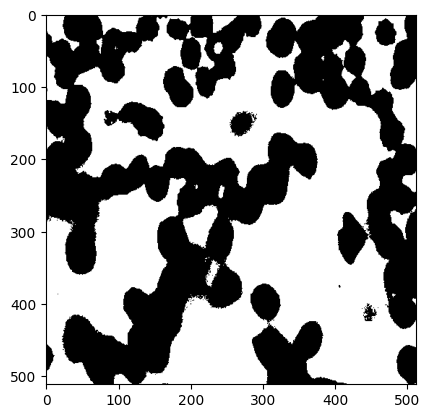

In [56]:
# bi reverse color 0 -> 1, 1 -> 0???
plt.imshow(pd_results.loc[599, "segmentation"], cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0013442601..0.9989539].


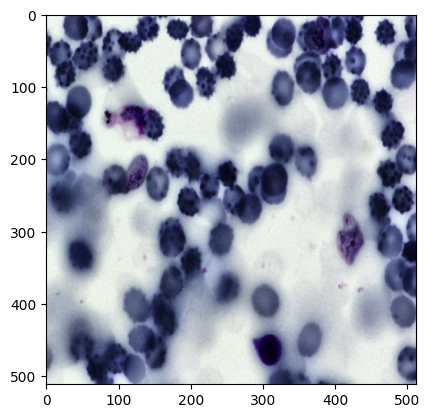

In [57]:
filename = pd_results.loc[599, "filename"]
img = np.load(os.path.join(images_dir, filename))
plt.imshow(img)